# Use pretrained models of scVI-hub for Tahoe100M

This notebook represent an example of how to perform downstream anaylsis on a pretrained SCVI model that was minified and saved in a model hub.
In this case we use the model that was trained based on the [Tahoe100M](https://doi.org/10.1101/2025.02.20.639398) dataset , by [Vevo Therapuetics](https://www.tahoebio.ai/news/open-sourcing-tahoe-100m). See link to model hub [here](https://huggingface.co/tahoebio/Tahoe-100M-SCVI-v1)

**Steps performed**:

1. Loading the minified data from AWS
2. Setting up minified model with minified data
3. Visualize the latent space
4. Perform differential expression and visualize with interactive volcano plot and heatmap using Plotly


In [1]:
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import scvi.hub
import seaborn as sns
import torch

In [2]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.3.2


In [3]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

We start by downloading the model from its hub

In [4]:
tahoe_hubmodel = scvi.hub.HubModel.pull_from_huggingface_hub(
    repo_name="vevotx/Tahoe-100M-SCVI-v1", cache_dir="."
)

/tmp/ipykernel_3654546/4207946461.py:1: UserWarning: No revision was passed, so the default (latest) revision will be used.
  tahoe_hubmodel = scvi.hub.HubModel.pull_from_huggingface_hub(


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

We can see the model card

In [5]:
# This will be a bit long to scroll, but has all the info
# tahoe_hubmodel

We will extract he model and the minifed adata

In [6]:
tahoe = tahoe_hubmodel.model
tahoe

INFO     Loading model...                                                                                          
INFO     File ./models--vevotx--Tahoe-100M-SCVI-v1/snapshots/b5283a73fbbed812a95264ace360da538b20af89/model.pt     
         already downloaded                                                                                        


SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: nb, 
latent_distribution: normal.
Training status: Trained
Model's adata is minified?: True

In [7]:
tahoe.adata

AnnData object with n_obs × n_vars = 95624334 × 62710
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'bc1_well', 'bc2_well', 'bc3_well', 'id', 'drugname_drugconc', 'drug', 'INT_ID', 'NUM.SNPS', 'NUM.READS', 'demuxlet_call', 'BEST.LLK', 'NEXT.LLK', 'DIFF.LLK.BEST.NEXT', 'BEST.POSTERIOR', 'SNG.POSTERIOR', 'SNG.BEST.LLK', 'SNG.NEXT.LLK', 'SNG.ONLY.POSTERIOR', 'DBL.BEST.LLK', 'DIFF.LLK.SNG.DBL', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'dataset', '_scvi_batch', '_scvi_labels', '_scvi_observed_lib_size', 'plate', 'Cell_Name_Vevo', 'Cell_ID_Cellosaur', 'observed_lib_size'
    var: 'gene_id', 'genome', 'SUB_LIB_ID'
    uns: '_scvi_adata_minify_type', '_scvi_manager_uuid', '_scvi_uuid'
    obsm: 'X_latent_qzm', 'X_latent_qzv', 'scvi_latent_qzm', 'scvi_latent_qzv'
    layers: 'counts'

In [8]:
tahoe.adata.obs.head()

,sample,species,gene_count,tscp_count,mread_count,bc1_wind,bc2_wind,bc3_wind,bc1_well,bc2_well,...,phase,pass_filter,dataset,_scvi_batch,_scvi_labels,_scvi_observed_lib_size,plate,Cell_Name_Vevo,Cell_ID_Cellosaur,observed_lib_size
BARCODE_SUB_LIB_ID,,,,,,,,,,,,,,,,,,,,,
01_001_052-lib_1105,smp_1783,hg38,1878,2893,3284,1,1,52,A1,A1,...,G2M,full,0,0,0,2893,4,PANC-1,CVCL_0480,2893
01_001_105-lib_1105,smp_1783,hg38,1765,2434,2764,1,1,105,A1,A1,...,G2M,full,0,0,0,2434,4,SW480,CVCL_0546,2434
01_001_165-lib_1105,smp_1783,hg38,3174,5691,6454,1,1,165,A1,A1,...,G2M,full,0,0,0,5691,4,SW1417,CVCL_1717,5691
01_003_094-lib_1105,smp_1783,hg38,1380,1804,2050,1,3,94,A1,A3,...,G2M,full,0,0,0,1804,4,SW1417,CVCL_1717,1804
01_003_164-lib_1105,smp_1783,hg38,1179,1514,1715,1,3,164,A1,A3,...,G1,full,0,0,0,1514,4,A498,CVCL_1056,1514


## Get the latent space and compute UMAP

In [9]:
SCVI_LATENT_KEY = "X_scVI"
latent = tahoe.get_latent_representation()
tahoe.adata.obsm[SCVI_LATENT_KEY] = latent
latent.shape

(95624334, 10)

In [10]:
# we visualize a subset of the results to avoid meaningless overplotting.
subset_adata = tahoe.adata[np.random.randint(0, tahoe.adata.shape[0], (1_000_000,))]
subset_adata

View of AnnData object with n_obs × n_vars = 1000000 × 62710
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'bc1_well', 'bc2_well', 'bc3_well', 'id', 'drugname_drugconc', 'drug', 'INT_ID', 'NUM.SNPS', 'NUM.READS', 'demuxlet_call', 'BEST.LLK', 'NEXT.LLK', 'DIFF.LLK.BEST.NEXT', 'BEST.POSTERIOR', 'SNG.POSTERIOR', 'SNG.BEST.LLK', 'SNG.NEXT.LLK', 'SNG.ONLY.POSTERIOR', 'DBL.BEST.LLK', 'DIFF.LLK.SNG.DBL', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'dataset', '_scvi_batch', '_scvi_labels', '_scvi_observed_lib_size', 'plate', 'Cell_Name_Vevo', 'Cell_ID_Cellosaur', 'observed_lib_size'
    var: 'gene_id', 'genome', 'SUB_LIB_ID'
    uns: '_scvi_adata_minify_type', '_scvi_manager_uuid', '_scvi_uuid'
    obsm: 'X_latent_qzm', 'X_latent_qzv', 'scvi_latent_qzm', 'scvi_latent_qzv', 'X_scVI'
    layers: 'counts'

In [11]:
subset_adata.X.shape

(1000000, 62710)

In [12]:
tahoe.view_anndata_setup()

Anndata setup with scvi-tools version 1.3.2.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': None,
│   'labels_key': None,
│   'size_factor_key': 'tscp_count',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

          Summary Statistics           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃     Summary Stat Key     ┃  Value   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│         n_batch          │    1     │
│         n_cells          │ 95624334 │
│ n_extra_categorical_covs │    0     │
│ n_extra_continuous_covs  │    0     │
│         n_labels         │    1     │
│       n_latent_qzm       │    10    │
│       n_latent_qzv       │    10    │
│          n_vars          │  62710   │
└──────────────────────────┴──────────┘

                       Data Registry                        
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Registry Key    ┃         scvi-tools Location          ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         X         │        adata.layers['counts']        │
│       batch       │       adata.obs['_scvi_batch']       │
│      labels       │      adata.obs['_scvi_labels']       │
│    latent_qzm     │    adata.obsm['scvi_latent_qzm']     │
│    latent_qzv     │    adata.obsm['scvi_latent_qzv']     │
│    minify_type    │ adata.uns['_scvi_adata_minify_type'] │
│ observed_lib_size │    adata.obs['observed_lib_size']    │
│    size_factor    │       adata.obs['tscp_count']        │
└───────────────────┴──────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [13]:
import gc

gc.collect()

17

### Visualization with batch correction (scVI)

In [14]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(subset_adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(subset_adata, min_dist=0.3)

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [15]:
# sc.pl.umap(
#    subset_adata,
#    color=["drug"],
#    frameon=False,
# )

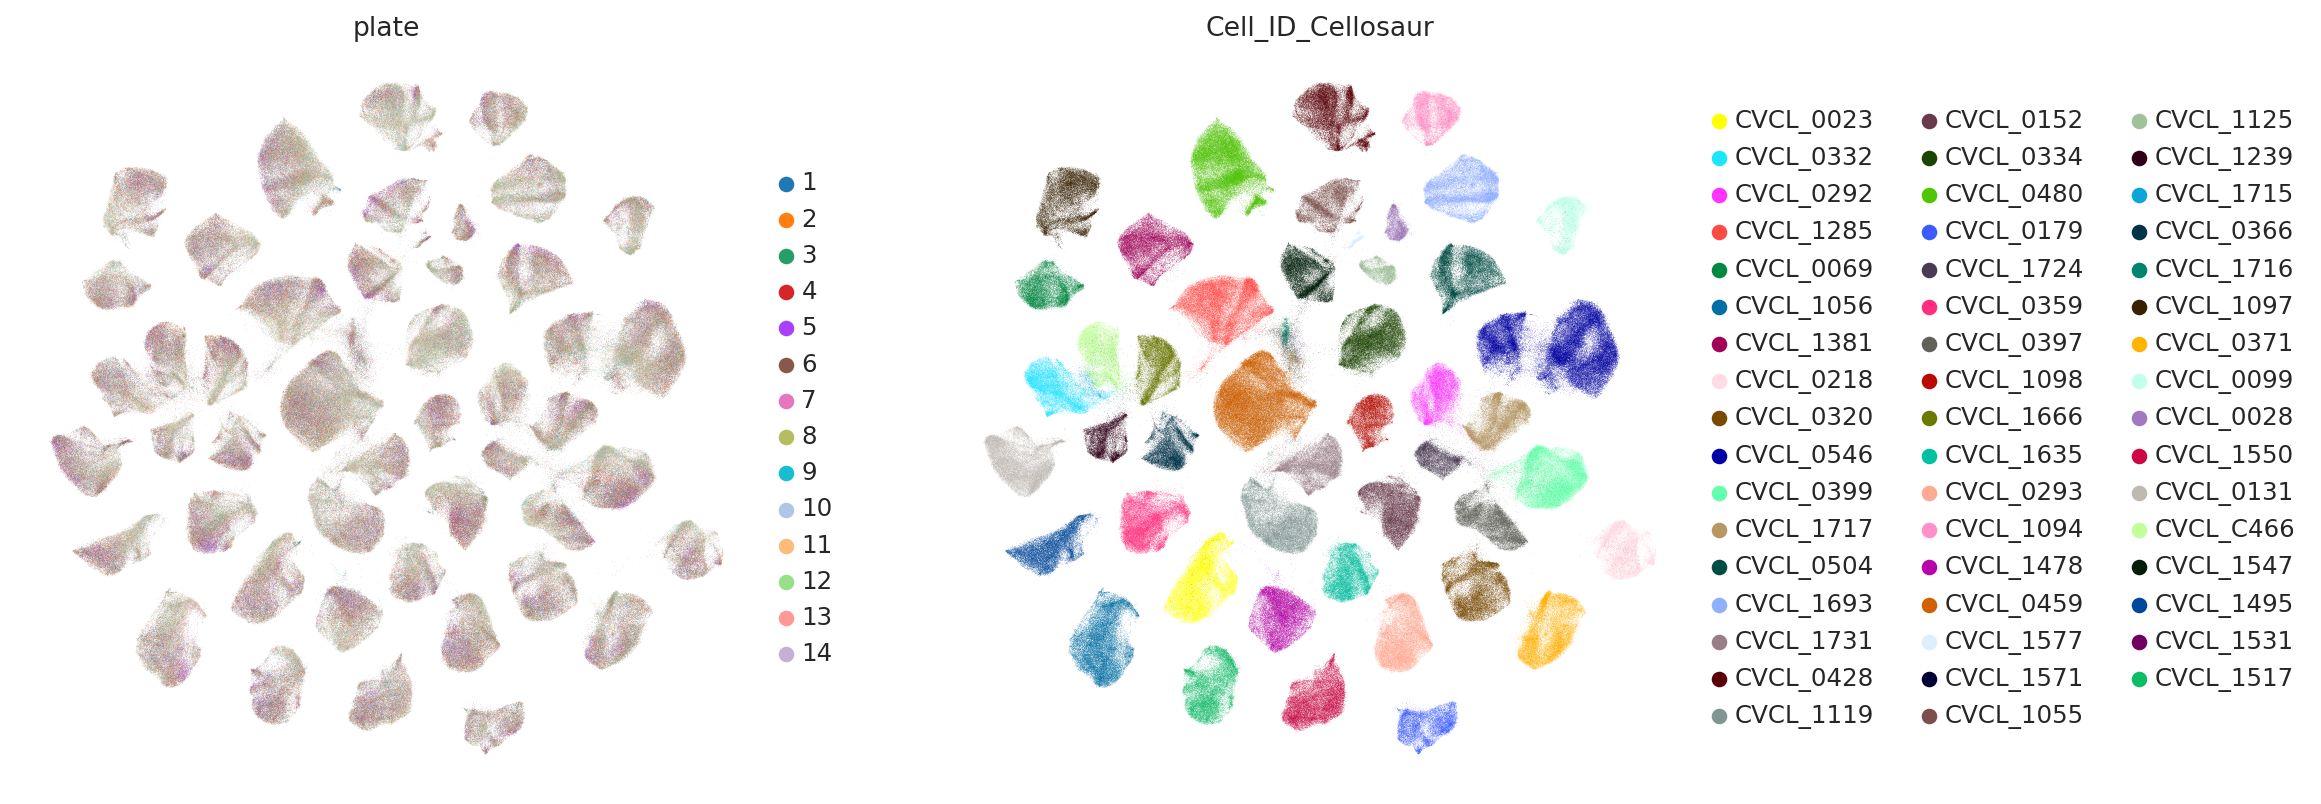

In [16]:
sc.pl.umap(
    subset_adata,
    color=["plate", "Cell_ID_Cellosaur"],
    ncols=2,
    frameon=False,
)

### Clustering on the scVI latent space

In [17]:
# neighbors were already computed using scVI
SCVI_CLUSTERS_KEY = "leiden_scVI"
sc.tl.leiden(subset_adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.5)

/tmp/ipykernel_3654546/788717315.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(subset_adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.5)


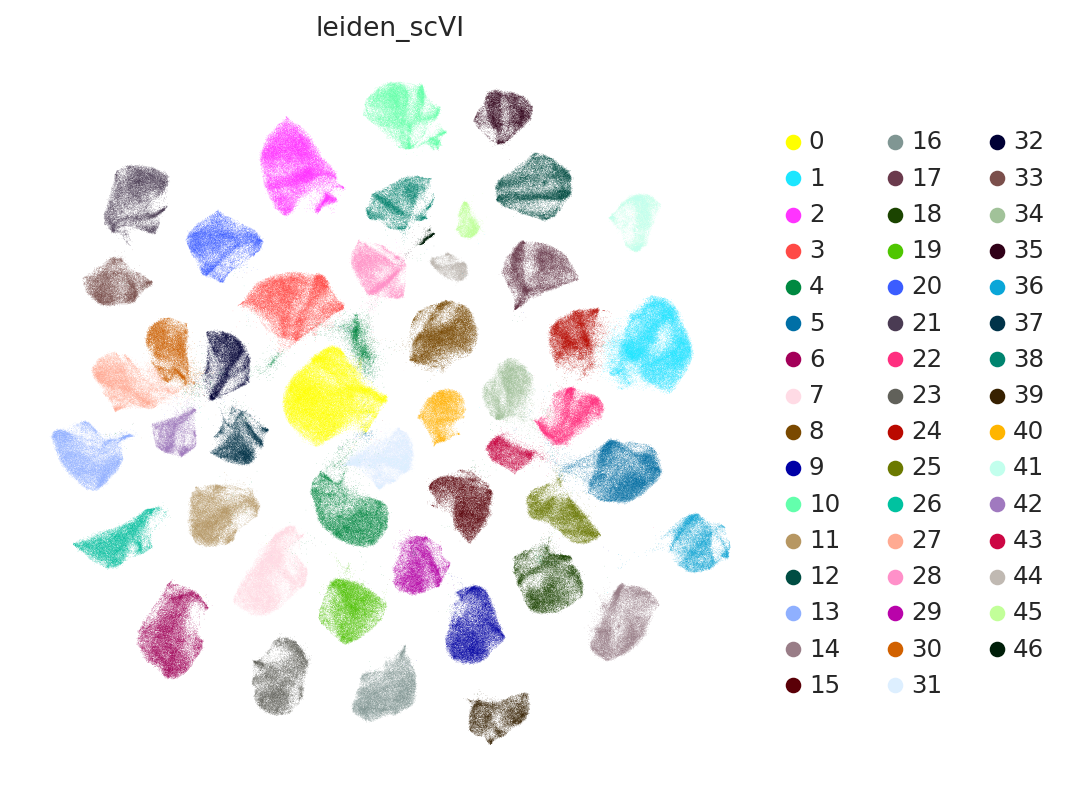

In [18]:
sc.pl.umap(
    subset_adata,
    color=[SCVI_CLUSTERS_KEY],
    frameon=False,
)

In [19]:
# integration of plates and cell type
pd.crosstab(subset_adata.obs.plate, subset_adata.obs.Cell_ID_Cellosaur)

Cell_ID_Cellosaur,CVCL_0023,CVCL_0332,CVCL_0292,CVCL_1285,CVCL_0069,CVCL_1056,CVCL_1381,CVCL_0218,CVCL_0320,CVCL_0546,...,CVCL_0371,CVCL_0099,CVCL_0028,CVCL_1550,CVCL_0131,CVCL_C466,CVCL_1547,CVCL_1495,CVCL_1531,CVCL_1517
plate,,,,,,,,,,,,,,,,,,,,,
1,1605,866,785,1649,699,1172,1128,1056,1648,3410,...,1543,473,285,1427,1423,1406,1049,905,23,1771
2,2331,1249,1288,2660,1063,1856,1624,1344,2035,5109,...,2093,679,494,1970,2240,1911,1606,1311,25,2282
3,1286,817,475,1533,538,1123,1031,537,1131,2394,...,1341,326,241,1520,1559,785,903,716,21,1570
4,2181,1157,1044,2310,1093,1867,1616,1089,1681,4242,...,1741,645,530,1734,2014,1361,1612,1274,30,1752
5,1931,1209,684,2282,1056,1975,1560,786,1463,3108,...,1361,532,546,1690,2210,1157,1417,1194,36,1727
6,2321,1122,1261,2508,1307,1935,1811,1153,1689,4736,...,1774,814,759,1763,2212,1754,1541,1364,26,1748
7,1379,1147,796,2001,968,1843,1492,693,1149,3210,...,1176,800,246,1408,1015,755,942,1200,10,764
8,2063,1550,1696,2856,1642,2380,2062,1472,1898,6383,...,2122,1664,443,1886,1592,1171,1460,1885,20,1018
9,1340,1084,1019,1896,967,1702,1322,924,1348,4024,...,1415,862,294,1291,1112,793,900,1212,13,846


/tmp/ipykernel_3654546/2378724135.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = subset_adata.obs.groupby(["leiden_scVI", "Cell_ID_Cellosaur"]).size().unstack(fill_value=0)


Text(0, 0.5, 'leiden_scVI')

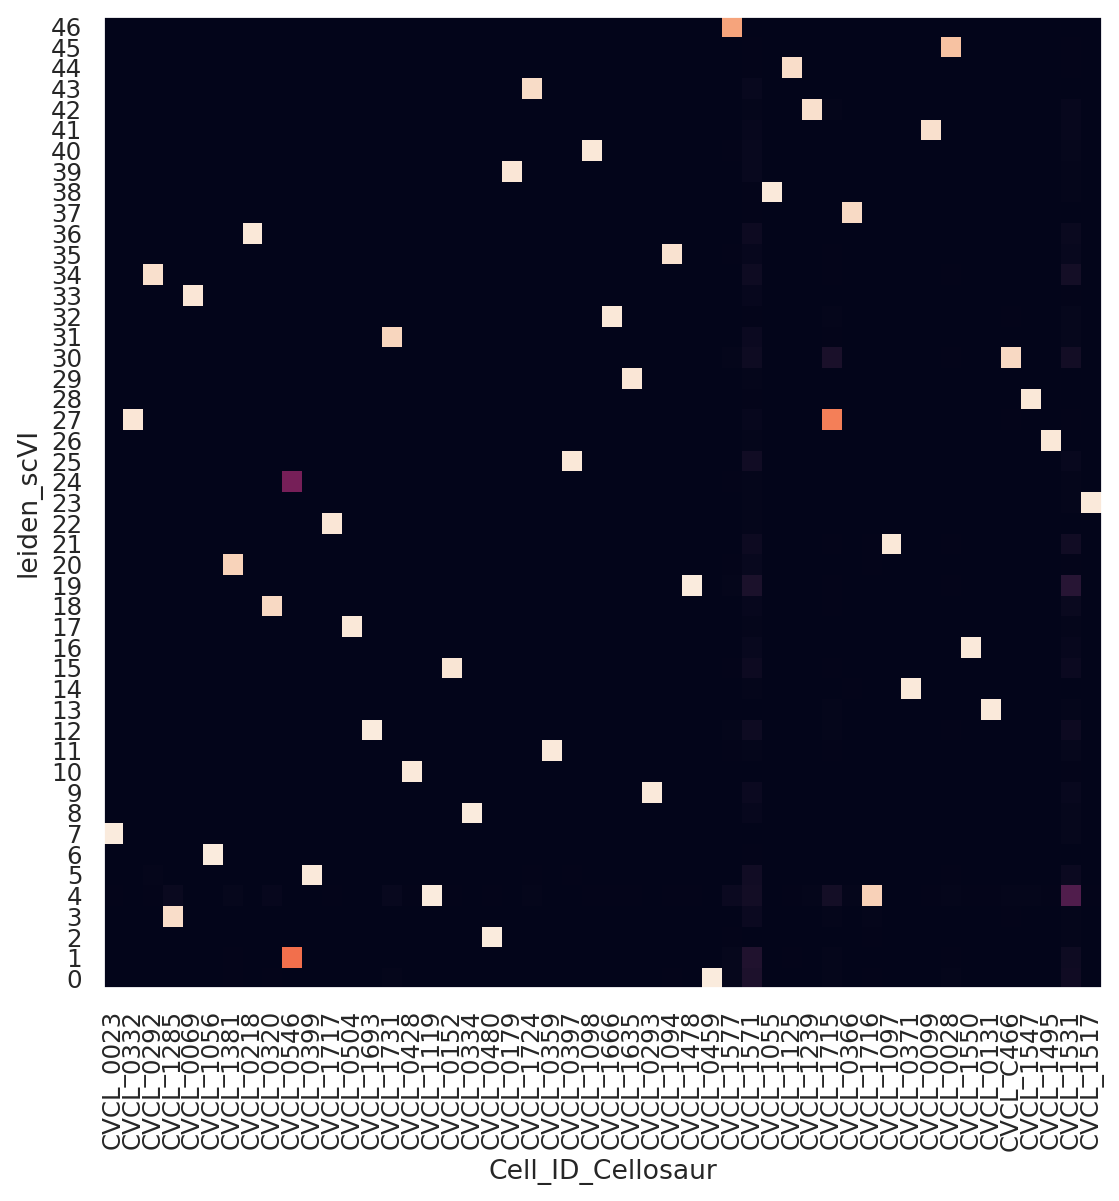

In [20]:
# integration of leiden clsuters and cell type
df = subset_adata.obs.groupby(["leiden_scVI", "Cell_ID_Cellosaur"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)
plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Cell_ID_Cellosaur")
plt.ylabel("leiden_scVI")

/tmp/ipykernel_3654546/1995441329.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = subset_adata.obs.groupby(["drug", "Cell_ID_Cellosaur"]).size().unstack(fill_value=0)


Text(0, 0.5, 'drug')

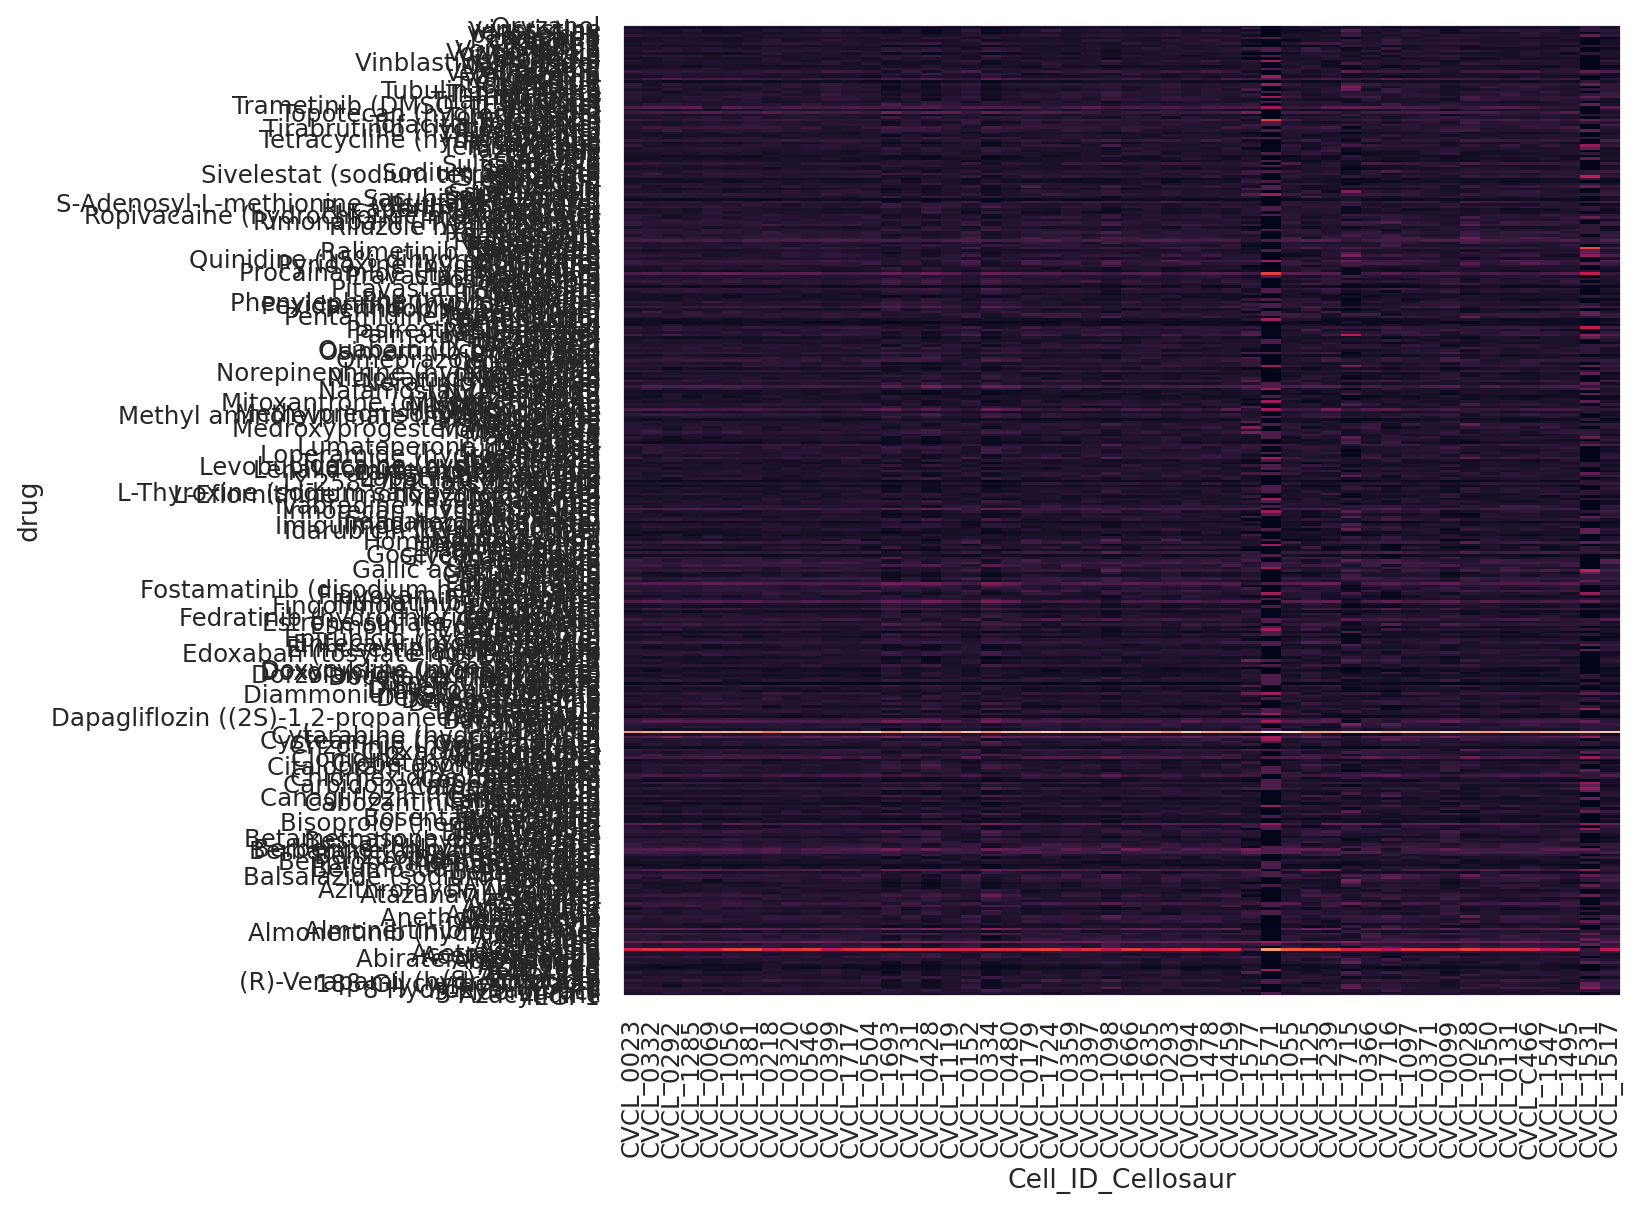

In [21]:
# integration of drugs and cell type (certain type of cancer are given certian type of drugs)
df = subset_adata.obs.groupby(["drug", "Cell_ID_Cellosaur"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)
plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Cell_ID_Cellosaur")
plt.ylabel("drug")

In [22]:
# from pprint import pprint
# pprint(tahoe.registry)

### SCANVI

Running scanvi from the scvi model will require the original counts matrix and cant be done, as count matrix is all 0.

In [23]:
tahoe.save("tahoe_tmp", save_anndata=True, overwrite=True)

In [24]:
tahoe_loaded = scvi.model.SCVI.load("tahoe_tmp", adata=tahoe.adata)

INFO     File tahoe_tmp/model.pt already downloaded                                                                


In [25]:
tahoe_loaded.minify_adata(minified_data_type="latent_posterior_parameters_with_counts")

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [26]:
# predict on drug?
tahoe_scanvi = scvi.model.SCANVI.from_scvi_model(
    tahoe_loaded,
    unlabeled_category="Unknown",
    labels_key="Cell_ID_Cellosaur",
)

In [27]:
tahoe_loaded.adata.X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 0 stored elements and shape (95624334, 62710)>

In [28]:
# tahoe_scanvi.train(max_epochs=1, n_samples_per_label=100)

### Perform Integration Analysis

In [29]:
from scib_metrics.benchmark import Benchmarker

bm = Benchmarker(
    subset_adata[np.random.randint(0, subset_adata.shape[0], (100_000,))],
    batch_key="plate",
    label_key="Cell_ID_Cellosaur",
    embedding_obsm_keys=["X_scVI"],
    n_jobs=-1,
)
bm.benchmark()

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:438: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:379: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.

INFO     50 clusters consist of a single batch or are too small. Skip.                                             


/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scib_metrics/metrics/_kbet.py:212: RuntimeWarning: Mean of empty slice
  final_score = np.nanmean(kbet_scores["kBET"])

rics:  70%|██████████████████████████████████████████                  | 7/10 [11:02<02:44, 54.78s/it, Batch correction: kbet_per_label]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [11:03<00:00, 663.18s/it]

                                                                                                                                        

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


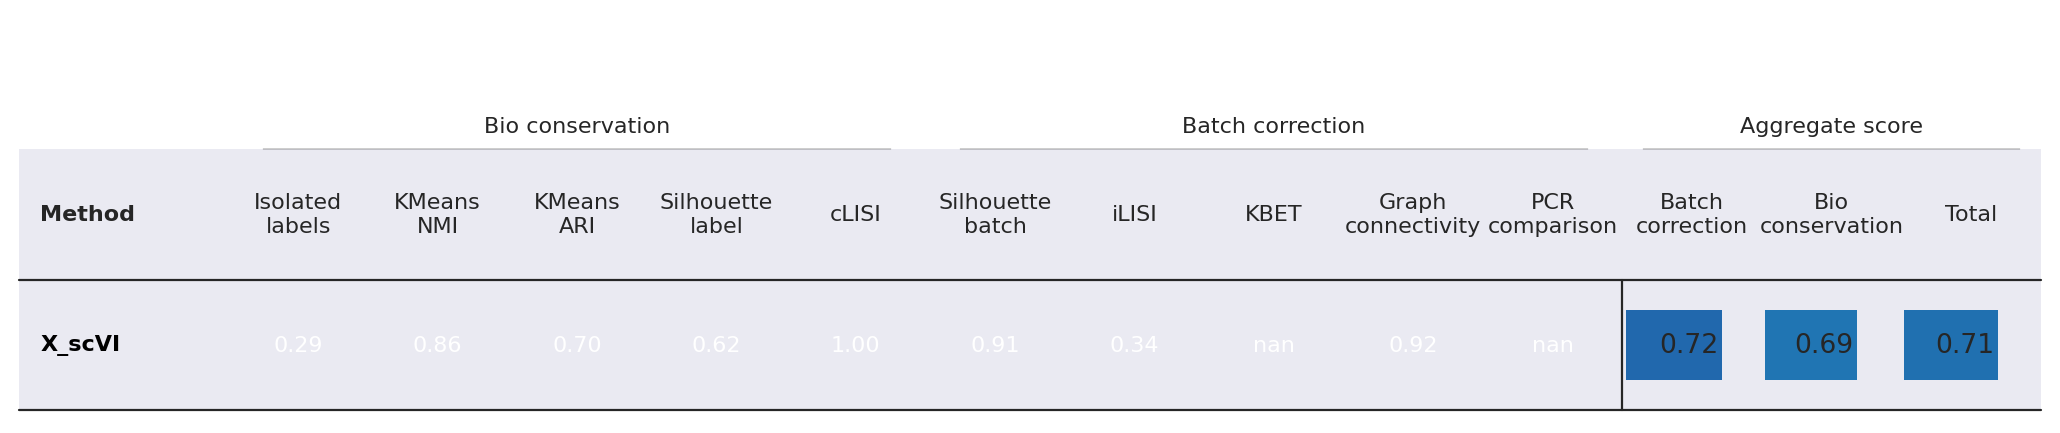

In [30]:
bm.plot_results_table(min_max_scale=False)

## Performing Differential Expression in scVI

While we only have access to the minified data, we can still perform downstream analysis using the generative part of the model.
For example here, we will do it on a cluster of DMSO_TF controls vs the drug Harringtonine that is used for protein synthesis inhibitor per the cell line CVCL_0459 which is typicaly associated with Lung large cell carcinoma, a sub type of NSCLC. 
We also choose to use the sub group of G2M cell cycle phase.

In [31]:
tahoe.adata.obs["drug"].value_counts().head()

drug
DMSO_TF                    2205786
Adagrasib                  1433284
Afatinib                    696323
Almonertinib (mesylate)     592031
Cytarabine                  551715
Name: count, dtype: int64

In [32]:
tahoe.adata.obs["Cell_ID_Cellosaur"].value_counts().head()

Cell_ID_Cellosaur
CVCL_0546    6040371
CVCL_0459    5736238
CVCL_0480    4089586
CVCL_1285    3307302
CVCL_0399    3013246
Name: count, dtype: int64

scVI provides several options to identify the two populations of interest.

In [33]:
cell_line = "CVCL_0459"
cell_cycle = "G2M"

drug1 = "Harringtonine"
cell_idx1 = np.logical_and(
    tahoe.adata.obs["Cell_ID_Cellosaur"] == cell_line,
    tahoe.adata.obs["drug"] == drug1,
    tahoe.adata.obs["phase"] == cell_cycle,
)
print(sum(cell_idx1), "cells from drug", drug1)

drug2 = "DMSO_TF"
cell_idx2 = np.logical_and(
    tahoe.adata.obs["Cell_ID_Cellosaur"] == cell_line,
    tahoe.adata.obs["drug"] == drug2,
    tahoe.adata.obs["phase"] == cell_cycle,
)
print(sum(cell_idx2), "cells of drug", drug2)

17297 cells from drug Harringtonine
126345 cells of drug DMSO_TF


A simple DE analysis can then be performed using the following command

In [ ]:
de_change = tahoe.differential_expression(
    idx1=cell_idx1,
    idx2=cell_idx2,
    all_stats=True,
    batch_correction=True,
    mode="change",
    delta=0.05,
    pseudocounts=1e-12,
)

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scvi/model/base/_rnamixin.py:420: UserWarning: Count statistics make no sense for minified model. Consider disabling all_stats.
  result = _de_core(


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
de_change.head()

Volcano plot with p-values

In [ ]:
de_change["log10_pscore"] = np.log10(de_change["proba_not_de"] + 1e-6)
de_change = de_change.join(tahoe.adata.var, how="inner")
de_change = de_change.loc[np.max(de_change[["scale1", "scale2"]], axis=1) > 1e-4]
de_change.head()

We will use external gene annotations data base to extend our data

In [ ]:
gene_annotations = sc.queries.biomart_annotations(
    org="hsapiens",
    attrs=["ensembl_gene_id", "gene_biotype"],
)

In [ ]:
gene_annotations.index = gene_annotations["ensembl_gene_id"]
gene_annotation_dict = gene_annotations["gene_biotype"].to_dict()

In [ ]:
# gene_annotations.head()

In [ ]:
de_change["Biotype"] = [gene_annotation_dict.pop(i, "Unannotated") for i in de_change["gene_id"]]
de_change["Biotype"].value_counts()

In [ ]:
de_change.head()

In [ ]:
import plotnine as p9

In [ ]:
(
    p9.ggplot(de_change, p9.aes("lfc_mean", "-log10_pscore", color="Biotype"))
    + p9.geom_point(
        de_change.query("Biotype == 'protein_coding'"), alpha=0.5
    )  # Plot other genes with transparence
    + p9.xlim(-5, 5)  # Set x limits
    + p9.ylim(0, 3)  # Set y limits
    + p9.geom_point(de_change.query("Biotype != 'protein_coding'"))
    + p9.labs(x="LFC mean", y="Significance score (higher is more significant)")
)

Display generated counts from scVI model, for top 4 genes

In [ ]:
upregulated_genes = de_change.loc[de_change["lfc_median"] > 0, ["gene_id"]].head(4)

In [ ]:
upregulated_genes

In [ ]:
upregulated_genes.index

In [ ]:
# get the generated expression from the minified model (will take time)
tahoe.adata[:, upregulated_genes.index] = tahoe.get_normalized_expression(
    gene_list=list(upregulated_genes.index), n_samples=10
)

## Future Work

Perform DE between each cell line and/or drug vs all other cell lines and/or drigs and make a dotplot of the result. In order to do this we will have to use a subset of data (both cells and genes) to save time.

Run advance models on this data such as SCANVI, MrVI using the AnnCollector dataloader.